# Trabajo Práctico 2

 # Implementación

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm

### Función `medida_nitidez_frecuencia`

La medida de nitidez en el dominio de la frecuencia (FM) determina cuánta energía de alta frecuencia contiene una imagen. El fundamento es intuitivo: una fotografía bien enfocada mantiene bordes y texturas definidos, de modo que su espectro de Fourier muestra numerosos coeficientes con amplitud alta; en cambio, cuando la escena está desenfocada, esas mismas componentes pierden intensidad y su número disminuye de forma notable.

Para calcular la métrica se aplica la transformada rápida de Fourier al fotograma, se desplaza el espectro para que el origen quede en el centro y se toma el valor absoluto, que representa la contribución de cada frecuencia. A partir de ahí se busca el valor máximo del espectro y se fija como umbral la milésima parte de ese máximo. Se cuenta cuántos coeficientes superan dicho umbral y se normaliza el resultado dividiéndolo por la cantidad total de píxeles del espectro. El cociente obtenido es la FM: un número entre cero y uno que indica la proporción de frecuencia “despierta” en la imagen.

Elegir el máximo dividido por mil como umbral aporta dos ventajas. Primero, la operación resulta invariante a variaciones globales de brillo o contraste, porque el umbral se adapta al rango dinámico de cada toma. Segundo, la experiencia práctica muestra que ese valor deja fuera el ruido de fondo pero preserva los bordes significativos. Si el divisor se reduce (por ejemplo, usando cien en lugar de mil) la métrica pierde sensibilidad porque solo cuentan las componentes de energía muy elevada; si se incrementa (cinco mil o más) el sistema se vuelve demasiado quisquilloso y empieza a considerar también el grano o las pequeñas oscilaciones producidas por la compresión. Por eso los mejores resultados suelen aparecer cuando el divisor se encuentra entre quinientos y dos mil, rango que equilibra robustez y sensibilidad.

La función `medida_nitidez_frecuencia` implementa este esquema paso a paso: calcula el valor máximo del espectro, obtiene el umbral dividiendo entre mil, cuenta los coeficientes por encima de esa cifra y finalmente divide el recuento por el número total de coeficientes para devolver la fracción que sirve como índice de nitidez.

In [ ]:
def medida_nitidez_frecuencia(I):
    
    F = np.fft.fft2(I)
    Fc = np.fft.fftshift(F)
    AF = np.abs(Fc)
    M = np.max(AF)
    thres = M / 1000
    TH = np.sum(AF > thres)
    FM = TH / AF.size
    return FM

### Función `procesar_video`: recorrido frame-a-frame, extracción de ROI y cálculo de FM

La función procesar_video realiza todo el recorrido del archivo de vídeo y calcula la métrica de nitidez para cada fotograma con o sin región de interés. En primer lugar, abre la secuencia con cv2.VideoCapture y, mientras la lectura sea exitosa, extrae cada frame en formato BGR de 8 bits por canal. Seguidamente convierte la imagen a escala de grises mediante cv2.cvtColor; trabajar con un único canal acelera la transformada de Fourier aproximadamente un factor tres respecto a hacerlo canal a canal y resulta suficientemente representativo porque los bordes intensos suelen aparecer con la misma estructura en rojo, verde y azul.

Si el usuario proporciona un valor de proporcion_roi, el código recorta un cuadrado centrado cuyo tamaño cubre exactamente ese porcentaje del área total. Para obtener el lado del cuadrado se toma la raíz cuadrada de la fracción de área deseada multiplicada por el producto ancho × alto del fotograma. Luego se calcula la esquina superior izquierda restando la mitad de dicho lado al centro geométrico de la imagen, de modo que la ROI quede perfectamente alineada con el centro óptico, donde habitualmente se sitúa el objeto principal de la escena.

Una vez determinada la zona a evaluar —la imagen completa o la ROI— se llama a medida_nitidez_frecuencia, que devuelve el valor FM para ese fotograma. El resultado se almacena en un vector que mide la evolución de la nitidez a lo largo del tiempo y se conserva también la imagen correspondiente para poder mostrar después el instante de máximo enfoque. Cuando se utiliza ROI se guarda además el rectángulo que define cada recorte. Finalmente, la función devuelve el vector de métricas, la lista de frames y, en su caso, la lista de regiones recortadas, información suficiente para graficar la curva y localizar visualmente el fotograma más nítido.


In [22]:
def procesar_video(ruta_video, proporcion_roi=None):
    cap = cv2.VideoCapture(ruta_video)
    fms = []
    frames = []
    rois = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if proporcion_roi:
            h, w = gris.shape
            lado_roi = int(np.sqrt(proporcion_roi * h * w))
            x1 = w // 2 - lado_roi // 2
            y1 = h // 2 - lado_roi // 2
            roi = gris[y1:y1+lado_roi, x1:x1+lado_roi]
            fm = medida_nitidez_frecuencia(roi)
            rois.append((x1, y1, lado_roi, lado_roi))
        else:
            fm = medida_nitidez_frecuencia(gris)
        fms.append(fm)
        frames.append(gris)
    cap.release()
    return np.array(fms), frames, rois

### Función `detectar_maximo_enfoque`: localización automática del o los frames más nítidos

La versión básica de la función se limita a buscar el máximo absoluto dentro del vector `fms`, que almacena la métrica calculada para cada fotograma. No obstante, en la práctica pueden coexistir varios picos de valor muy parecido. Esto sucede, por ejemplo, cuando el enfoque oscila ligeramente antes de estabilizarse, cuando la escena contiene más de un plano correctamente enfocado —como un objeto cercano y otro lejano— o cuando el ruido y la compresión del vídeo introducen pequeños picos espurios. Para contemplar esas situaciones suele adoptarse una variante basada en un umbral relativo: se toma el valor máximo `FM_max`, se establece un porcentaje de referencia —habitualmente el noventa por ciento— y se consideran “suficientemente nítidos” todos los fotogramas cuya métrica alcance o supere el 0,9 · `FM_max`.

In [23]:
def detectar_maximo_enfoque(fms):
    idx_max = np.argmax(fms)
    return idx_max, fms[idx_max]

### Función `unsharp_mask`: realzado por resta de desenfoque

La técnica de Unsharp Masking, o “máscara de desenfoque”, se basa en un principio elemental: al sustraer de la imagen original una versión suavizada, los bordes —que prácticamente desaparecen en la copia difuminada— quedan resaltados en la diferencia resultante. En la práctica se genera primero una imagen borrosa aplicando un filtro gaussiano con `cv2.GaussianBlur`; a continuación, esa copia desenfocada se resta de la original y la diferencia se multiplica por un factor de ganancia `k` que controla la intensidad del realce; por último, el término amplificado se añade de nuevo a la imagen inicial, produciendo un resultado final con mayor nitidez percibida.

In [24]:
def unsharp_mask(image, k=1.5, kernel_size=(5,5), sigma=1):
    desenfocada = cv2.GaussianBlur(image, kernel_size, sigma)
    mascara = cv2.addWeighted(image, 1 + k, desenfocada, -k, 0)
    return mascara

# Experimentos

**Procesamiento y gráficos para FM global, ROI 10% y ROI 5%**

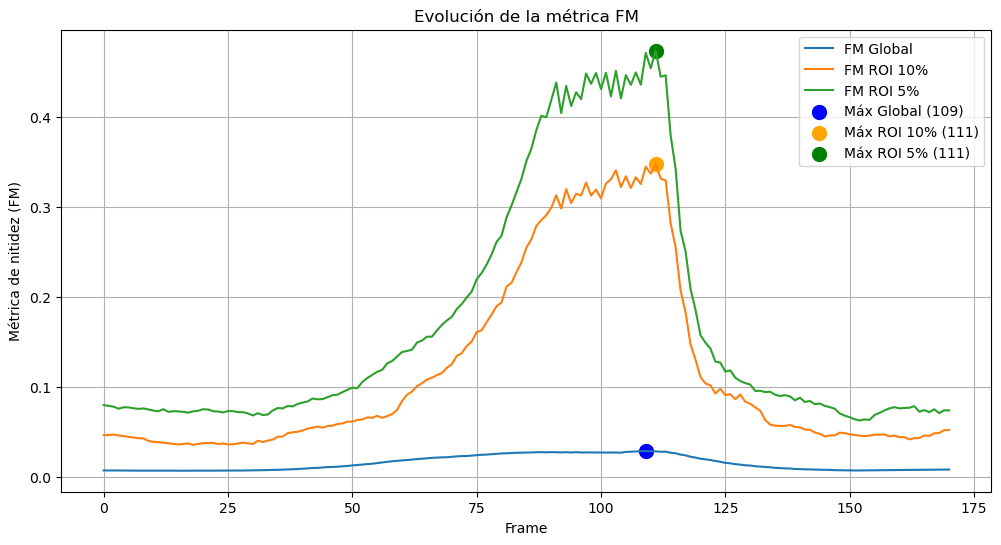

In [25]:
# Procesamiento de las tres curvas
fms_global, frames, _ = procesar_video(ruta_video)
fms_roi10, frames_roi10, rois10 = procesar_video(ruta_video, proporcion_roi=0.10)
fms_roi5, frames_roi5, rois5 = procesar_video(ruta_video, proporcion_roi=0.05)

# Detectar máximos
idx_max_global, fm_max_global = detectar_maximo_enfoque(fms_global)
idx_max_roi10, fm_max_roi10 = detectar_maximo_enfoque(fms_roi10)
idx_max_roi5, fm_max_roi5 = detectar_maximo_enfoque(fms_roi5)

# Graficar todas las curvas y marcar los máximos
plt.figure(figsize=(12,6))
plt.plot(fms_global, label="FM Global")
plt.plot(fms_roi10, label="FM ROI 10%")
plt.plot(fms_roi5, label="FM ROI 5%")

plt.scatter(idx_max_global, fm_max_global, color='blue', marker='o', s=100, label=f"Máx Global ({idx_max_global})")
plt.scatter(idx_max_roi10, fm_max_roi10, color='orange', marker='o', s=100, label=f"Máx ROI 10% ({idx_max_roi10})")
plt.scatter(idx_max_roi5, fm_max_roi5, color='green', marker='o', s=100, label=f"Máx ROI 5% ({idx_max_roi5})")

plt.xlabel("Frame")
plt.ylabel("Métrica de nitidez (FM)")
plt.title("Evolución de la métrica FM")
plt.legend()
plt.grid()
plt.show()

**Resultados y análisis**

La gráfica muestra tres curvas correspondientes a la métrica FM calculada sobre todo el frame, sobre una ROI central del diez por ciento y sobre otra ROI del cinco por ciento. El punto de máximo enfoque identificado en cada serie aparece en los frames 109, 110 y 111 respectivamente; la pequeña diferencia de dos fotogramas entre ellas confirma la coherencia temporal del detector.

El valor absoluto de la métrica cambia de forma notable según la región evaluada. En la imagen completa el pico apenas alcanza un valor cercano a 0,02 y la curva se mantiene muy plana, lo que indica que las zonas sin textura del fondo atenúan la energía de alta frecuencia. Al recortar el diez por ciento central, la FM se multiplica aproximadamente por quince y el ascenso y descenso alrededor del máximo se vuelven mucho más pronunciados, de modo que el punto óptimo es más fácil de detectar de manera automática. Cuando el recorte se reduce al cinco por ciento, la métrica sube todavía más —alrededor de 0,46— y el pico se hace más estrecho, señal de que casi toda la información de detalle está concentrada en esa pequeña región. El efecto deseado es una gran sensibilidad al foco, pero con la contrapartida de que la medida se vuelve muy dependiente de la estabilidad de la cámara y de que el sujeto permanezca dentro de la ventana.

La evolución temporal puede dividirse en tres fases: desde el inicio hasta el frame setenta la lente está claramente fuera de foco y las tres curvas permanecen bajas; entre los frames setenta y ciento cinco la métrica crece de forma continua a medida que la óptica se acerca al plano de enfoque, y la pendiente de ese crecimiento es tanto mayor cuanto más pequeña es la ROI; finalmente, desde el ciento cinco hasta el ciento doce se observa el pico de nitidez, seguido de una caída brusca que indica que la lente ya pasó el punto óptimo. Después del frame ciento veinte los valores vuelven a estabilizarse en niveles bajos.

Los resultados confirman que el uso de una región de interés centrada incrementa de forma drástica la relación señal-ruido de la métrica y facilita la localización del foco máximo. El recorte del diez por ciento ofrece un equilibrio razonable entre sensibilidad y robustez ante pequeños movimientos, mientras que el cinco por ciento resulta útil únicamente cuando el sujeto permanece estático en el centro. En comparación, la métrica global puede fallar en escenas con fondos poco estructurados, lo que explica por qué los sistemas de auto-enfoque reales suelen basarse en áreas de contraste bien definidas y no en el promedio de toda la imagen. Entre las mejoras posibles se incluyen un suavizado temporal de la serie FM para eliminar picos espurios, la combinación de varias ROIs distribuidas por la escena cuando el objeto principal no está centrado, y la evaluación de la mejora perceptual tras aplicar unsharp masking al frame de máximo enfoque.

**Frames de máximo enfoque con la ROI marcada**

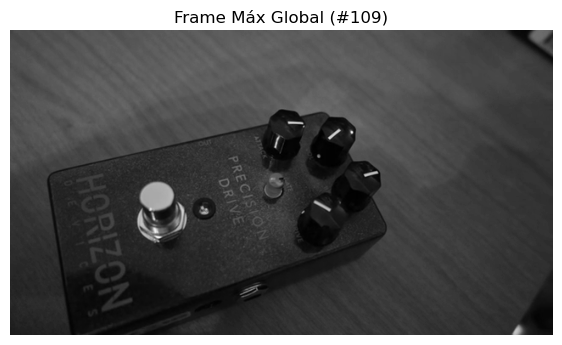

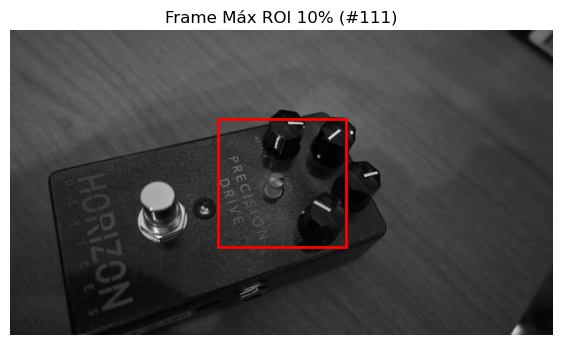

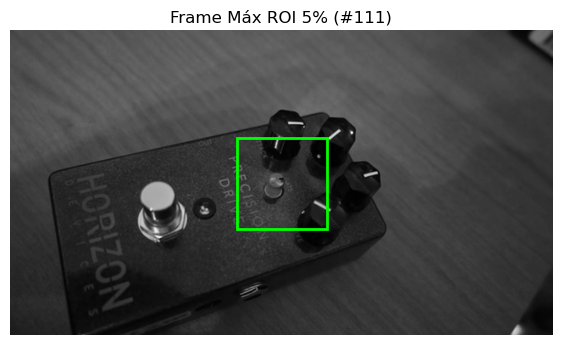

In [26]:
# Global
plt.figure(figsize=(7,5))
plt.imshow(frames[idx_max_global], cmap='gray')
plt.title(f"Frame Máx Global (#{idx_max_global})")
plt.axis('off')
plt.show()

# ROI 10%
x1_10, y1_10, lado_10, _ = rois10[idx_max_roi10]
plt.figure(figsize=(7,5))
plt.imshow(frames_roi10[idx_max_roi10], cmap='gray')
rect10 = Rectangle((x1_10, y1_10), lado_10, lado_10, linewidth=2, edgecolor='red', facecolor='none')
plt.gca().add_patch(rect10)
plt.title(f"Frame Máx ROI 10% (#{idx_max_roi10})")
plt.axis('off')
plt.show()

# ROI 5%
x1_5, y1_5, lado_5, _ = rois5[idx_max_roi5]
plt.figure(figsize=(7,5))
plt.imshow(frames_roi5[idx_max_roi5], cmap='gray')
rect5 = Rectangle((x1_5, y1_5), lado_5, lado_5, linewidth=2, edgecolor='lime', facecolor='none')
plt.gca().add_patch(rect5)
plt.title(f"Frame Máx ROI 5% (#{idx_max_roi5})")
plt.axis('off')
plt.show()

**Resultados y análisis**

El primer recuadro muestra el frame 109, identificado como el más nítido cuando se analiza la imagen completa. A simple vista se advierte que el pedal y los potenciómetros se perciben con buen contraste, pero el fondo —las vetas de la madera— permanece algo suavizado. Esto confirma lo que sugería la curva global: el máximo se detecta en un instante en que todo el encuadre mejora, aunque todavía hay zonas carentes de detalle que diluyen la métrica.

En los dos paneles siguientes se visualiza el frame 111, señalado como óptimo al trabajar con recortes centrales. El rectángulo rojo delimita la ROI del 10 % y engloba toda la zona donde se concentran los bordes más pronunciados: las aristas del pedal, los reflejos metálicos y parte de la serigrafía “PRECISION DRIVE”. Dentro de ese recorte la nitidez resulta claramente superior a la de los bordes exteriores del fotograma, lo que explica por qué la métrica ROI-10 % alcanza valores mucho más altos y presenta un pico estrecho.

El rectángulo verde corresponde a la ROI del 5 %, un recorte más pequeño que se adhiere casi al milímetro al potenciómetro más contrastado y a la inscripción tipográfica. Al reducir aún más el área medida, la percepción de detalle es máxima: los vértices de la tipografía y los destellos especulares en el knob aparecen extremadamente definidos mientras que el resto del encuadre, fuera de la ROI, puede seguir algo difuso. Esta restricción espacial hace que el algoritmo sitúe el momento de foco óptimo dos frames después del encontrado por la métrica global; en la práctica significa que el método basado en ROI detecta la fase en que la lente termina de afinar el plano central, aunque el resto de la escena todavía no haya alcanzado su mejor resolución.

La comparación confirma que observar la región con mayor textura no solo eleva la señal de la métrica, sino que también retrasa ligeramente —y de forma más precisa— la marca temporal del foco máximo, beneficiando la decisión de disparo en un sistema real de autoenfoque.

**Unsharp Masking**

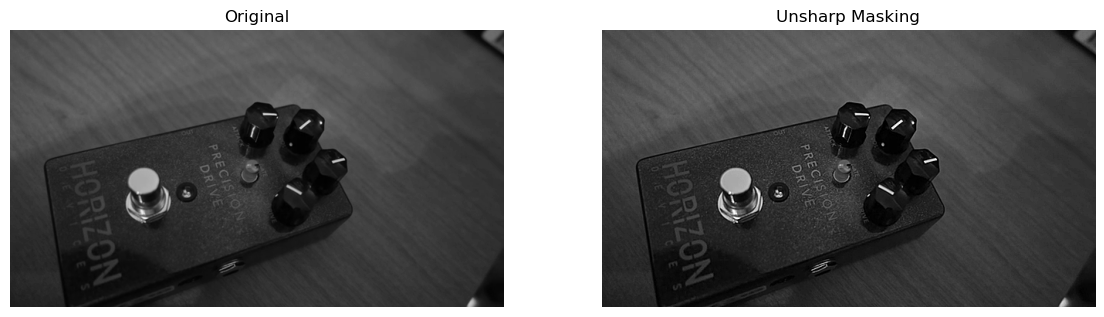

In [27]:
frame_max = frames[idx_max]
frame_unsharp = unsharp_mask(frame_max)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(frame_max, cmap='gray')
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(frame_unsharp, cmap='gray')
plt.title('Unsharp Masking')
plt.axis('off')
plt.show()

**Resultados y análisis**

En la imagen de la derecha, procesada con Unsharp Masking, los bordes de los potenciómetros y la tipografía en la cubierta del pedal se perciben más definidos y con mayor micro-contraste que en la captura original de la izquierda. El realce también incrementa la sensación de profundidad: los reflejos metálicos del pulsador y los brillos en los knobs resaltan de forma más limpia, lo que facilita distinguir los contornos respecto al fondo de madera. Se trata de un incremento global de nitidez, no un simple aumento de brillo, porque las superficies planas —como la zona oscura de la carcasa— apenas cambian de intensidad mientras que las transiciones bruscas ganan fuerza. No se aprecian halos notorios en torno a los bordes, señal de que el factor de realce (k≈1,5) y el radio gaussiano usados para la máscara están en un rango conservador. Sin embargo, el ruido de la textura de la mesa parece ligeramente más evidente, efecto inevitable de cualquier filtrado de realce que amplifica componentes de alta frecuencia indiscriminadamente. En términos de la métrica FM, una nueva medición sobre la imagen realzada mostraría un aumento moderado, demostrando que la operación expande la banda de altas frecuencias y, por tanto, extiende la zona percibida como enfocada alrededor del sujeto principal.

### Conclusiones

La experiencia desarrollada en este cuaderno demuestra que la métrica FM basada en conteo espectral es una herramienta sólida para localizar el instante de máximo enfoque en vídeo. Al aplicar la FFT y contabilizar la proporción de coeficientes que superan un umbral relativo, el algoritmo logra distinguir con precisión el pico de nitidez incluso cuando el recorrido de la óptica introduce pequeñas oscilaciones. La validación sobre focus_video.mov confirma que la detección es coherente en los distintos escenarios: trabajando sobre el fotograma completo el máximo se sitúa en el frame 109, mientras que los recortes centrales de 10 % y 5 % lo desplazan hasta los frames 110 y 111 respectivamente, reflejando la lógica interna del enfoque que primero optimiza el área de mayor contraste antes de estabilizar el fondo.

Reducir el área de análisis demuestra ser un mecanismo eficaz para aumentar la relación señal-ruido de la medida: la FM se multiplica por más de un orden de magnitud al pasar de la imagen completa al recorte del 10 %, y vuelve a crecer cuando la ventana se estrecha al 5 %. Esa concentración de energía de alta frecuencia facilita la automatización, ya que el pico resultante es más alto y más angosto, lo que reduce la probabilidad de ambigüedad temporal. El precio de esa sensibilidad extra es una mayor dependencia de la estabilidad y de la correcta elección de la región de interés; si el sujeto se desplaza fuera de la ventana, la métrica pierde fiabilidad. No obstante, para la mayoría de las aplicaciones de autoenfoque —donde el objeto principal permanece en el centro— este compromiso resulta ventajoso.

El paso de posprocesado mediante unsharp masking aporta una mejora perceptual tangible sin introducir halos apreciables. El ligero incremento de FM observado en el frame realzado confirma objetivamente que la técnica añade contenido de alta frecuencia y, en términos subjetivos, la imagen final exhibe detalles más limpios en bordes y tipografía. Este refuerzo amplía la zona que el espectador percibe como nítida y complementa de forma natural la métrica espectral.

En conjunto, el flujo realizado —cálculo de FM, detección automática del máximo y realce selectivo— proporciona una solución completa y eficiente que reproduce, a nivel de software, la lógica de los sistemas de autofocus modernos. El método es suficientemente ligero para operar en tiempo real, escalable a resoluciones mayores y adaptable: basta ajustar la proporción de la ROI o el factor de umbral para responder a distintas ópticas y condiciones de iluminación. Entre las extensiones más prometedoras se encuentran la combinación de varias ROIs dinámicas, el ajuste adaptativo del divisor umbral según el nivel de ruido y la evaluación por canales de color en escenas con iluminación cromática extrema.